In [6]:
import math

import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from trieste.experimental.plotting import (
    plot_bo_points,
    plot_function_2d,
    plot_mobo_history,
    plot_mobo_points_in_obj_space,
)

import trieste
from trieste.acquisition.function import ExpectedHypervolumeImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.data import Dataset
from trieste.models import TrainableModelStack
from trieste.models.gpflow import build_gpr, GaussianProcessRegression
from trieste.space import Box, SearchSpace
from trieste.objectives.multi_objectives import VLMOP2
from trieste.acquisition.multi_objective.pareto import (
    Pareto,
    get_reference_point,
)

np.random.seed(1793)
tf.random.set_seed(1793)

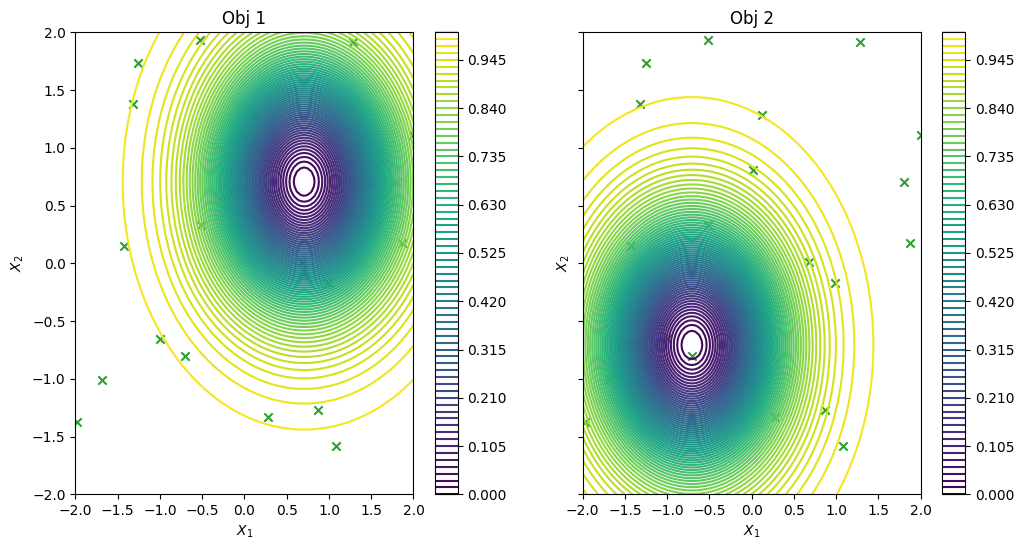

In [7]:
vlmop2 = VLMOP2(2)
observer = trieste.objectives.utils.mk_observer(vlmop2.objective)
mins = [-2, -2]
maxs = [2, 2]
search_space = Box(mins, maxs)
num_objective = 2

num_initial_points = 20
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

_, ax = plot_function_2d(
    vlmop2.objective,
    mins,
    maxs,
    contour=True,
    title=["Obj 1", "Obj 2"],
    figsize=(12, 6),
    colorbar=True,
    xlabel="$X_1$",
    ylabel="$X_2$",
)
plot_bo_points(initial_query_points, ax=ax[0, 0], num_init=num_initial_points)
plot_bo_points(initial_query_points, ax=ax[0, 1], num_init=num_initial_points)
plt.show()

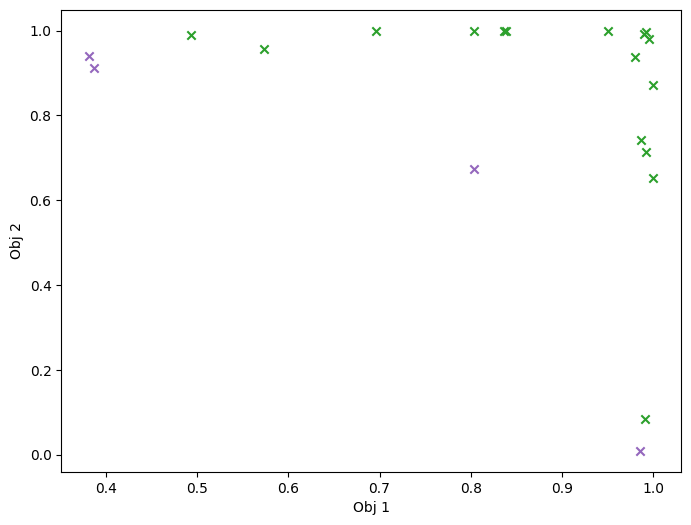

In [8]:
plot_mobo_points_in_obj_space(initial_data.observations)
plt.show()

In [10]:
def build_stacked_independent_objectives_model(data: Dataset, num_output: int, search_space: SearchSpace) -> TrainableModelStack:
    gprs = []
    for idx in range(num_output):
        single_obj_data = Dataset(
            data.query_points, tf.gather(data.observations, [idx], axis=1)
        )
        gpr = build_gpr(single_obj_data, search_space, likelihood_variance=1e-7)
        gprs.append((GaussianProcessRegression(gpr), 1))

    return TrainableModelStack(*gprs)

model = build_stacked_independent_objectives_model(
    initial_data, num_objective, search_space
)

In [11]:
ehvi = ExpectedHypervolumeImprovement()
rule: EfficientGlobalOptimization = EfficientGlobalOptimization(builder=ehvi)

num_steps = 30
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
result = bo.optimize(num_steps, initial_data, model, acquisition_rule=rule)

Optimization completed without errors


In [13]:
model = build_stacked_independent_objectives_model(
    initial_data, num_objective, search_space
)

from trieste.acquisition.function import Fantasizer

batch_ehvi = Fantasizer(ExpectedHypervolumeImprovement())
batch_rule: EfficientGlobalOptimization = EfficientGlobalOptimization(
    builder=batch_ehvi, num_query_points=3
)
num_steps = 10
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
batch_result = bo.optimize(
    num_steps, initial_data, model, acquisition_rule=batch_rule
)

Optimization completed without errors


Dataset(query_points=<tf.Tensor: shape=(50, 2), dtype=float64, numpy=
array([[ 0.98924624, -0.17137558],
       [ 0.86681231, -1.26760722],
       [-0.51932234,  1.93463179],
       [-1.97660607, -1.37710094],
       [ 0.67895793,  0.00844018],
       [ 1.99747194,  1.10739269],
       [ 0.12191317,  1.28791266],
       [ 1.08250607, -1.58389293],
       [ 1.28695613,  1.92018082],
       [-1.42779547,  0.15022282],
       [-0.99856247, -0.65544437],
       [-1.68777975, -1.01426944],
       [-0.70299194, -0.80199664],
       [ 0.02030318,  0.80381827],
       [ 1.86754216,  0.17632315],
       [ 0.27694617, -1.33199758],
       [-0.51240119,  0.33250402],
       [-1.25380952,  1.7357604 ],
       [ 1.79893865,  0.70484533],
       [-1.319588  ,  1.37722714],
       [ 0.47365126,  0.52336202],
       [-0.05752379, -0.02358038],
       [ 0.16301077,  0.18132177],
       [-0.27688558, -0.28438595],
       [-0.14374992, -0.1643967 ],
       [ 0.3055039 ,  0.31227811],
       [ 0.64646581,

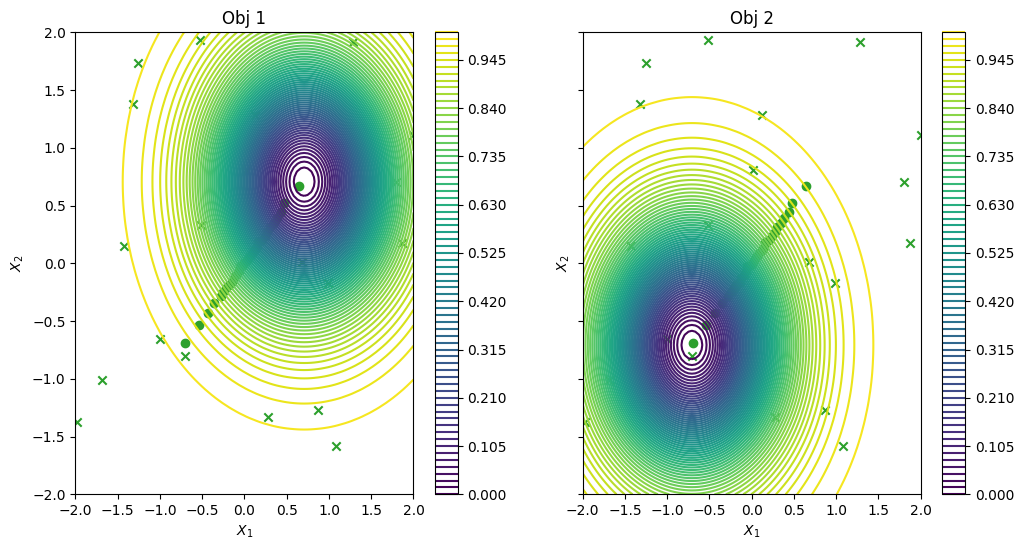

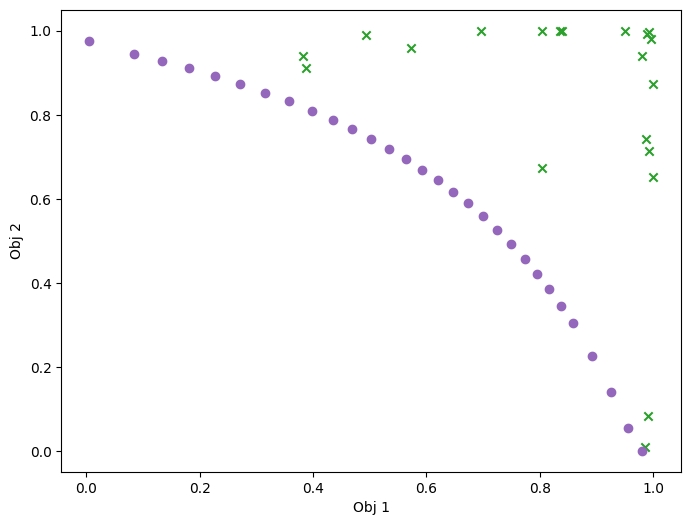

In [15]:
dataset = result.try_get_final_dataset()
print(dataset)
data_query_points = dataset.query_points
data_observations = dataset.observations

_, ax = plot_function_2d(
    vlmop2.objective,
    mins,
    maxs,
    contour=True,
    figsize=(12, 6),
    title=["Obj 1", "Obj 2"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    colorbar=True,
)
plot_bo_points(data_query_points, ax=ax[0, 0], num_init=num_initial_points)
plot_bo_points(data_query_points, ax=ax[0, 1], num_init=num_initial_points)
plt.show()

plot_mobo_points_in_obj_space(data_observations, num_init=num_initial_points)
plt.show()